In [1]:
# Importing required modules and packages
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Import matplotlib to display graphs
import matplotlib.pyplot as plt 

#Import pandas to display confusion matrix in a pretty way
import pandas as pd

# Import os to get modules for loading data
import os

# import random for sampling during data load and in the map function
import random

#initializing the random seed so that we get consistent results
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Initializing Input and Batch sizes

In [2]:
input_shape = (224, 224, 3)
batch_size = 20
num_classes = 5
diagnostics=False

# Loading Data

In [3]:
!cp '/content/drive/MyDrive/MachineLearning/Linnaeus 5 256X256.rar' '/content/' 
get_ipython().system_raw("unrar x '/content/Linnaeus 5 256X256.rar'")

In [4]:

path='/content/Linnaeus 5 256X256'
categories = os.listdir(os.path.join(path, 'train'))
if diagnostics: print("categories found =", categories, len(categories))

train_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'training'
  )

validation_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'validation'
  )


if diagnostics: print("class names found =" , train_image_dataset.class_names)

def crop_images(images, labels):
  '''
  Expecting categories to be names of subfolders and the images belonging to each 
  of the subfolders be stored inside them. While reading the images, they are resized to 256x256x3
  and then cropped to 224x224x3 based on the way the paper describes (randomly between 4 corners and center)
  diagnostics: bool (default False), If True it will print a lot of debug information

  '''
  # In order to clip the image in either from top-left, top-right, bottom-left, bottom-right or center, 
  # we create an array of possible start positions
  corners_list = [0, (256-input_shape[0])//2, 256-input_shape[0]]
  
  # Sampling one number from the list of start positions
  offset_height = offset_width = random.sample(corners_list, 1)[0]
  
  images = tf.image.per_image_standardization(images-127)
  images = images/tf.math.reduce_max(tf.math.abs(images))
  return  tf.image.crop_to_bounding_box(images, offset_height, offset_width, input_shape[0], input_shape[0]), labels


validation_datasource = validation_image_dataset.map(crop_images)
validation_datasource = validation_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

datasource = train_image_dataset.map(crop_images)
datasource = datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)



Found 6000 files belonging to 5 classes.
Using 5400 files for training.
Found 6000 files belonging to 5 classes.
Using 600 files for validation.


In [5]:
for i, (images, label) in enumerate( datasource): 

  print(images[i].shape, np.max(np.abs(images[i])), "min =", np.min(images[i]))
  print(images[i+1].shape,np.max(np.abs(images[i+1])), "min =", np.min(images[i+1]))
  break

(224, 224, 3) 0.7182552 min = -0.7182552
(224, 224, 3) 0.74124175 min = -0.74124175


In [6]:
test_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'test')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , seed=2
  )

test_datasource = test_image_dataset.map(crop_images)
test_datasource = test_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

Found 2000 files belonging to 5 classes.


# Building the VGG model

In [7]:
def build_vgg(filter_size=64, fc_units = 4096, num_classes = 1000, conv_padding='same'):
  '''
  Calling this function without any changes in the parameter valuese will give 
  the D-variant (16 layer) model as per the paper with the only difference being 
  in the activation function of the layers. The paper says the activation should be relu,
  but after a lot of trial and error, it was found that elu activation ensured that the 
  units wouldn't die in the process of training leading to fixed values in the outputs
  https://arxiv.org/pdf/1409.1556v6.pdf

  filter_size = int (default 64), The depth of convolution filters in the paper are multiples of 64
      , the common factor is defined as a parameter here to give flexibility for smaller versions of VGG
  fc_units = int (default= 4096), Size of the FC layers
  num_classes = int(default 1000), Number of classes that the images have to be classified into (size of the last FC layer)
  conv_padding: (default = 'same'), can either be 'valid' or 'same'. This is the padding of the Convolution layers.
  
  '''
  input = Input (shape=input_shape, batch_size = batch_size)

  # First Conv Block of filter size  64
  x = Conv2D(filters = filter_size, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_1_1')(input)
  x = Conv2D(filters = filter_size, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_1_2')(x)

  x = MaxPool2D(pool_size=(2,2), strides = (2,2), name='maxpool_1')(x)

  # Second Conv block of filter size 128
  x = Conv2D(filters = filter_size*2, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_2_1')(x)
  x = Conv2D(filters = filter_size*2, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_2_2')(x)

  x = MaxPool2D(pool_size=(2,2), strides = (2,2), name='maxpool_2')(x)

  # Third Conv block of filter size 256
  x = Conv2D(filters = filter_size*4, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_3_1')(x)
  x = Conv2D(filters = filter_size*4, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_3_2')(x)
  x = Conv2D(filters = filter_size*4, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_3_3')(x)

  x = MaxPool2D(pool_size=(2,2), strides = (2,2), name='maxpool_3')(x)

  #Fourth Conv Block of filteer size 512
  x = Conv2D(filters = filter_size*8, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_4_1')(x)
  x = Conv2D(filters = filter_size*8, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_4_2')(x)
  x = Conv2D(filters = filter_size*8, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_4_3')(x)

  x = MaxPool2D(pool_size=(2,2), strides = (2,2), name='maxpool_4')(x)

  # Fifth Conv Block of filter size 512
  x = Conv2D(filters = filter_size*8, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_5_1')(x)
  x = Conv2D(filters = filter_size*8, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_5_2')(x)
  x = Conv2D(filters = filter_size*8, kernel_size=(3,3), strides = (1,1)
             , activation= 'elu', padding = conv_padding
             , name='conv_5_3')(x)

  x = MaxPool2D(pool_size=(2,2), strides = (2,2), name='maxpool_5')(x)

  x = Flatten(name='flatten')(x)
  # Conv and MaxPool layers are done, declaring FC layers next

  x = Dense(fc_units, activation='elu', name='fc_1')(x)
  x = Dropout(0.5, name='dropout_1')(x)
  x = Dense(fc_units, activation='elu', name='fc_2')(x)
  x = Dropout(0.5, name='dropout_2')(x)

  #Final Output layer
  output = Dense(num_classes, activation='softmax', name='output')(x)

  model = Model(inputs = input, outputs = output, name='vgg16')
  model.summary()
  return model



# Half sized VGG16

In [48]:
model_2 = build_vgg(filter_size=32, num_classes=num_classes, conv_padding='same')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(20, 224, 224, 3)]       0         
_________________________________________________________________
conv_1_1 (Conv2D)            (20, 224, 224, 32)        896       
_________________________________________________________________
conv_1_2 (Conv2D)            (20, 224, 224, 32)        9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (20, 112, 112, 32)        0         
_________________________________________________________________
conv_2_1 (Conv2D)            (20, 112, 112, 64)        18496     
_________________________________________________________________
conv_2_2 (Conv2D)            (20, 112, 112, 64)        36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (20, 56, 56, 64)          0     

## Training the model

In [49]:
#adam = tf.keras.optimizers.Adam(learning_rate=0.05) # Trying a high learning rate
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_2.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [50]:
metrics = model_2.fit(datasource
          , epochs= 50
          
          , validation_data = validation_datasource
          , validation_steps = 5
          , shuffle= True
          , callbacks=callbacks
          )


Epoch 1/50
270/270 [==============================] - 67s 241ms/step - loss: 1.5603 - categorical_accuracy: 0.2728 - val_loss: 1.5071 - val_categorical_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 1.50708, saving model to vgg16.h5
Epoch 2/50
270/270 [==============================] - 64s 238ms/step - loss: 1.4048 - categorical_accuracy: 0.3906 - val_loss: 1.3337 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss improved from 1.50708 to 1.33367, saving model to vgg16.h5
Epoch 3/50
270/270 [==============================] - 64s 238ms/step - loss: 1.2898 - categorical_accuracy: 0.4476 - val_loss: 1.2502 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss improved from 1.33367 to 1.25022, saving model to vgg16.h5
Epoch 4/50
270/270 [==============================] - 64s 237ms/step - loss: 1.2324 - categorical_accuracy: 0.4794 - val_loss: 1.2879 - val_categorical_accuracy: 0.3900

Epoch 00004: val_loss did not improve from 1.25022
Epoch 5/50
270/270 [==========

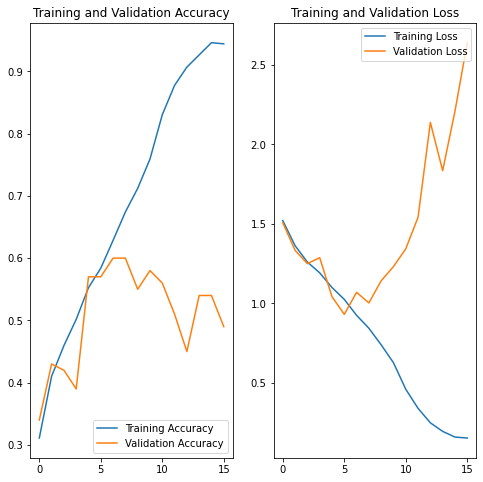

In [59]:

acc = metrics.history['categorical_accuracy']
val_acc = metrics.history['val_categorical_accuracy']

loss = metrics.history['loss']
val_loss = metrics.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Model with unseen data

In [61]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  if i > 40:
    break
  pred = model_2(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

[0. 1. 0. 0. 0.] 	 [0.026735   0.75479394 0.01279395 0.03252182 0.17315526]
[0. 1. 0. 0. 0.] 	 [0.03274518 0.38936576 0.04756283 0.09760881 0.43271747]
[1. 0. 0. 0. 0.] 	 [0.2676084  0.01923319 0.54541415 0.01446293 0.15328133]
[0. 0. 0. 0. 1.] 	 [0.435447   0.12984738 0.32875255 0.05612518 0.04982784]
[0. 0. 0. 0. 1.] 	 [0.16166173 0.4480878  0.04718498 0.19491842 0.14814705]
[0. 0. 0. 1. 0.] 	 [0.5608375  0.01816423 0.109129   0.00328241 0.30858687]
[1. 0. 0. 0. 0.] 	 [0.01179002 0.20600633 0.01103725 0.5932426  0.1779238 ]
[1. 0. 0. 0. 0.] 	 [0.1177501  0.45667613 0.01943839 0.2167525  0.18938287]
[1. 0. 0. 0. 0.] 	 [0.00353308 0.13969313 0.01598393 0.16393764 0.6768522 ]
[0. 0. 0. 0. 1.] 	 [0.38268444 0.3067909  0.22131167 0.02827153 0.06094147]


### Confusion Matrix

In [73]:
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,flower,bird,berry,dog,other
flower,54,5,14,3,3
bird,9,39,8,15,16
berry,16,6,46,1,13
dog,1,18,1,48,6
other,7,20,3,7,61


In [74]:
#!cp /content/vgg16.h5 '/content/drive/MyDrive/MachineLearning/'

# Quarter sized VGG16

In [8]:
model = build_vgg(filter_size=16, num_classes=num_classes, conv_padding='same')


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(20, 224, 224, 3)]       0         
_________________________________________________________________
conv_1_1 (Conv2D)            (20, 224, 224, 16)        448       
_________________________________________________________________
conv_1_2 (Conv2D)            (20, 224, 224, 16)        2320      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (20, 112, 112, 16)        0         
_________________________________________________________________
conv_2_1 (Conv2D)            (20, 112, 112, 32)        4640      
_________________________________________________________________
conv_2_2 (Conv2D)            (20, 112, 112, 32)        9248      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (20, 56, 56, 32)          0     

## Training the model


In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [10]:
# Saving the model when we reach a good min loss valid
model_checkpoint = ModelCheckpoint(filepath='vgg16_quarter.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   save_freq='epoch',
                                   verbose = 1)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.00001,
                               restore_best_weights = True,
                               patience=10,
                               verbose = 1
                               )

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=3,
                                         mode ='min',
                                         min_delta=0.001,
                                         min_lr=1e-10,
                                         verbose = 1)


callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]

In [11]:
metrics = model.fit(datasource
          , epochs= 50
          , validation_data = validation_datasource
          , validation_steps = 5
          , shuffle= True
          , callbacks=callbacks
          )


Epoch 1/50
270/270 [==============================] - 53s 75ms/step - loss: 2.6237 - categorical_accuracy: 0.3259 - val_loss: 1.5100 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.50999, saving model to vgg16_quarter.h5
Epoch 2/50
270/270 [==============================] - 19s 72ms/step - loss: 1.3475 - categorical_accuracy: 0.4143 - val_loss: 1.5367 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss did not improve from 1.50999
Epoch 3/50
270/270 [==============================] - 19s 72ms/step - loss: 1.2605 - categorical_accuracy: 0.4674 - val_loss: 1.3085 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss improved from 1.50999 to 1.30848, saving model to vgg16_quarter.h5
Epoch 4/50
270/270 [==============================] - 20s 74ms/step - loss: 1.2212 - categorical_accuracy: 0.5007 - val_loss: 1.4717 - val_categorical_accuracy: 0.3800

Epoch 00004: val_loss did not improve from 1.30848
Epoch 5/50
270/270 [============================

Text(0.5, 1.0, 'Accuracy')

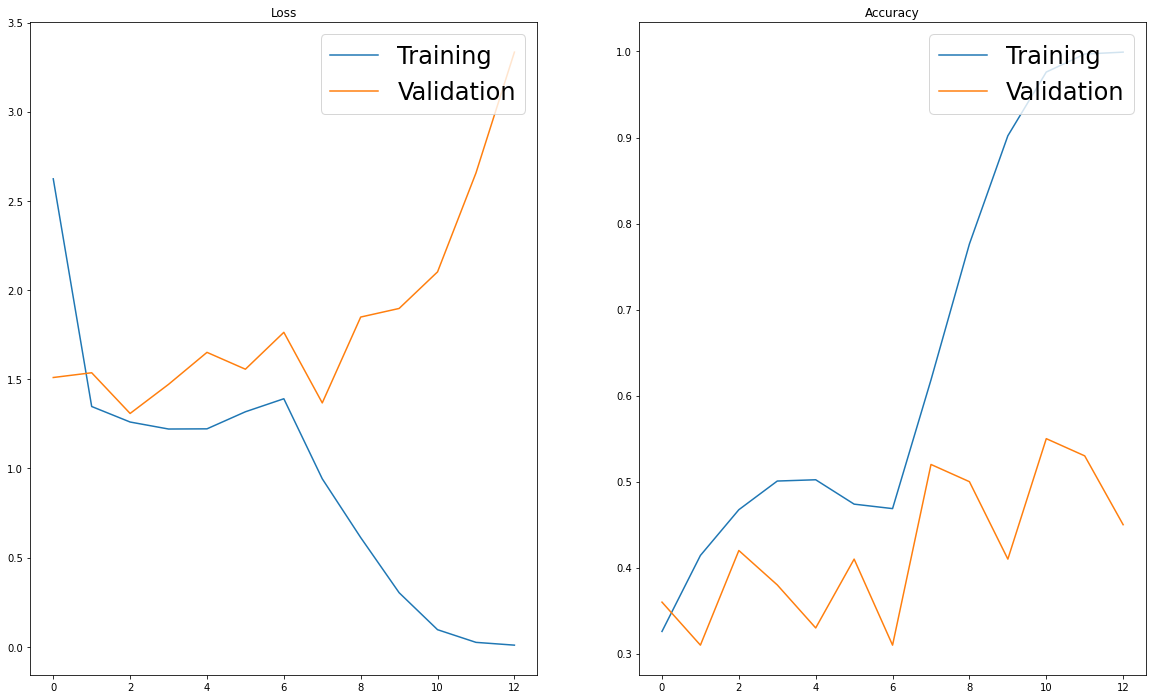

In [16]:
plt.figure(figsize=(20,12))

plt.subplot(1,2,1)
plt.plot(metrics.history['loss'], label='Training')
plt.plot(metrics.history['val_loss'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(metrics.history['categorical_accuracy'], label='Training')
plt.plot(metrics.history['val_categorical_accuracy'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Accuracy')

## Testing quarter size VGG16

In [13]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  if i > 40:
    break
  pred = model(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

print("number of labels =", len(labels), " predictions =", len(predictions))
# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

number of labels = 20  predictions = 820
[0. 0. 0. 0. 1.] 	 [0.1049897  0.10255653 0.20486319 0.28284848 0.30474207]
[0. 0. 0. 0. 1.] 	 [0.19398993 0.25876555 0.14309242 0.11372118 0.29043093]
[0. 0. 0. 0. 1.] 	 [0.24913569 0.3314616  0.36503893 0.01642968 0.0379341 ]
[1. 0. 0. 0. 0.] 	 [0.062418   0.01655457 0.00067896 0.26349974 0.6568487 ]
[0. 0. 0. 1. 0.] 	 [0.6688895  0.16000511 0.06360839 0.05596662 0.05153032]
[0. 1. 0. 0. 0.] 	 [0.00737886 0.06916492 0.0242643  0.62088996 0.27830192]
[0. 0. 0. 0. 1.] 	 [0.10866045 0.0967219  0.09748133 0.37092972 0.32620665]
[0. 0. 0. 1. 0.] 	 [0.02046039 0.54587317 0.2388286  0.17613521 0.01870261]
[0. 0. 1. 0. 0.] 	 [0.05083339 0.13283207 0.01134666 0.32191342 0.4830745 ]
[0. 1. 0. 0. 0.] 	 [0.01836638 0.1508963  0.03595354 0.64360267 0.15118109]


### Confusion Matrix

In [14]:
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,other,bird,dog,berry,flower
other,77,68,20,12,3
bird,20,85,31,22,5
dog,13,67,64,12,4
berry,6,29,7,69,51
flower,8,23,8,42,74


In [15]:
#!cp /content/vgg16_quarter.h5 '/content/drive/MyDrive/MachineLearning/'